## Setup

Here, we're setting up the environment. For the request of the doc, we will list out location of each part of code responsible for the requirements in the assignment prompt.

In [1]:
!nvidia-smi # first thing to check, otherwise, we are changing to another server

Tue Dec  5 00:19:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1A:00.0 Off |                  N/A |
| 22%   23C    P8    20W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 22%   

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
gpus_str = '0'
gpus_list = gpus_str.split(',')
os.environ['CUDA_VISIBLE_DEVICES'] = gpus_str
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # error only

In [4]:
import random
import queue
import math
import yaml
from tqdm.notebook import tqdm
from typing import Union, List, Dict

In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-12-05 00:19:11.328631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 00:19:11.328669: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 00:19:11.328713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import F1Score
from sklearn.metrics import f1_score

In [8]:
from bayes_opt import BayesianOptimization

In [9]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## Modeling

In this homework, we are implementing algorithms to fine tune hyperparameters for the image classification
task using a subset of the Federated EMNIST dataset with samples of digits only (10 classes). The dataset can be downloaded from [link](https://nuwildcat-my.sharepoint.com/personal/swl0126_ads_northwestern_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fswl0126%5Fads%5Fnorthwestern%5Fedu%2FDocuments%2FAssignment4data&ga=1). We will first load the data.

### Load data

In [92]:
X_train = np.load('data/train_X.npy')
X_test = np.load('data/test_X.npy')
y_train = np.load('data/train_y.npy')
y_test = np.load('data/test_y.npy')
X_train.shape, X_test.shape, y_train.shape, y_test.shape # 50/50 split for train/test

((9517, 28, 28), (1049, 28, 28), (9517,), (1049,))

Below we have a quick visualization to check the images, and we can see that it's pretty legible. We also did a quick histogram for all the labels - it's reasonably balanced for both train and test.

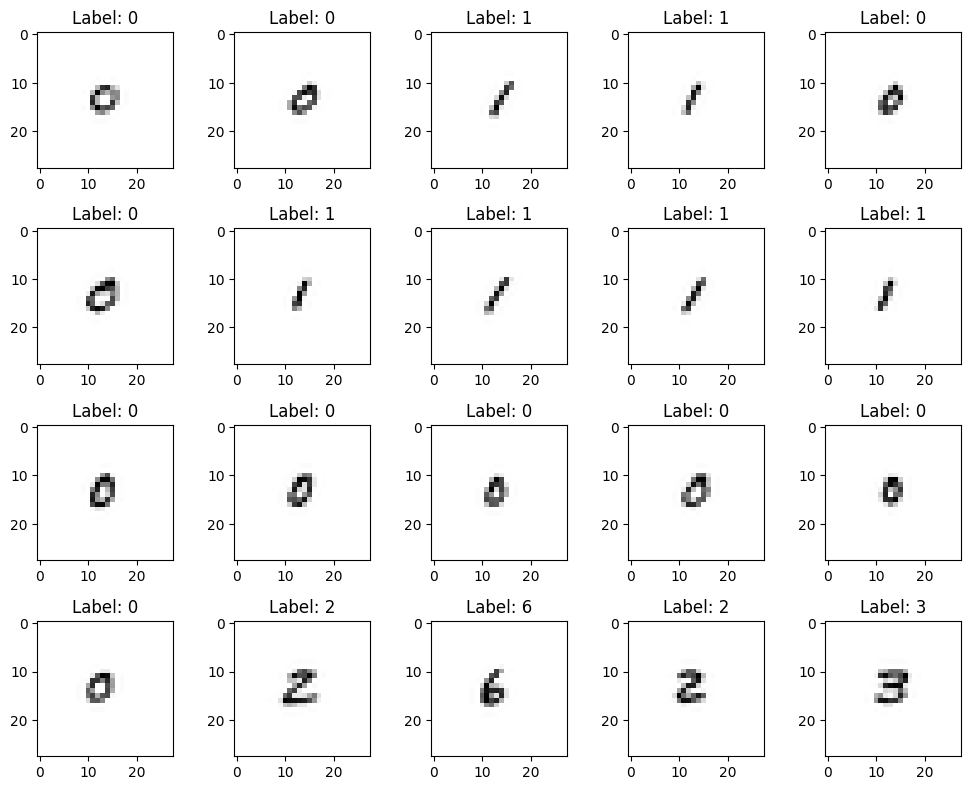

In [93]:
# def plot_images(images, labels, num=5):
#     """ Calculate the number of rows and columns """
#     num_rows = math.ceil(num / 5) # display 5 images per row
#     num_cols = min(num, 5)

#     plt.figure(figsize=(10, 2 * num_rows))
#     for i in range(num):
#         plt.subplot(num_rows, num_cols, i+1)
#         plt.imshow(images[i], cmap='gray')
#         plt.title("Label: {}".format(labels[i]))
#     plt.tight_layout()
#     plt.show()

# plot_images(X_train, y_train, num=20)

Text(0.5, 1.0, 'Train Labels')

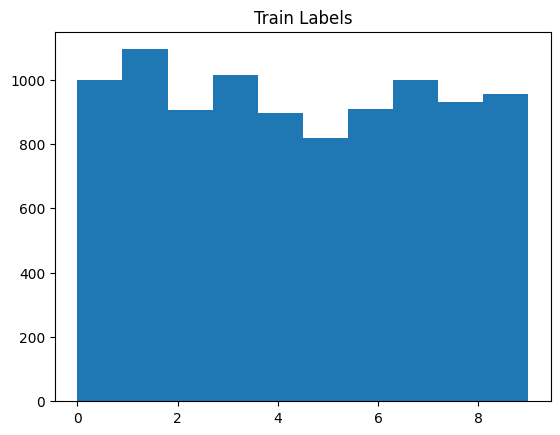

In [94]:
# # check distribution for train data
# plt.hist(y_train)
# plt.title("Train Labels")

Text(0.5, 1.0, 'Test Label')

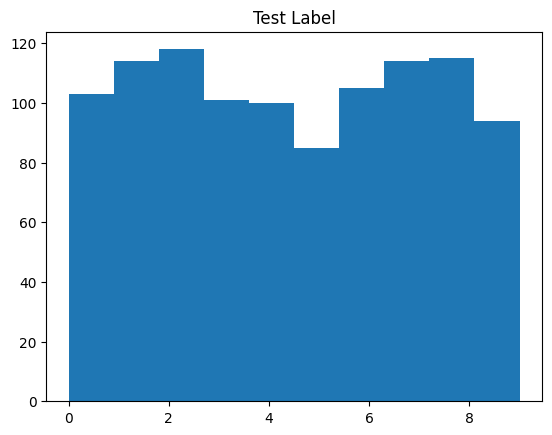

In [95]:
# # check distribution for test data
# plt.hist(y_test)
# plt.title("Test Label")

In [96]:
# reshape for NN input
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_train.shape, X_test.shape

((9517, 784), (1049, 784))

As instructed, we use train X.npy, train y.npy for training and split them into 80% of training and
20% of validation set. And we use test X.npy, test y.npy for testing. The test data should not be used in
any part of the training and the hyperparameter tuning.

In [97]:
# 80/20 train_val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7613, 784), (1904, 784), (7613,), (1904,))

### Define model

Per requirments, we are using a 2-layer feed forward network (one hidden layer and one output layer) with
128 hidden units for the image classification task. We are also using SGD as the optimizer and macro-averaged F1 score as the evaluation metric (Note that `tf.keras.metrics.F1Score` needs to take in one-hoted matrix, so we are making the conversion). We will train the network with mini-batches and early stopping on validation loss so that we can stop when converged.

In [17]:
# # test the vanilla f1 measure
# metric = tf.keras.metrics.F1Score(average='macro', threshold=0.5)
# y_true = np.array([[1, 0, 0],
#                    [0, 1, 1],
#                    [1, 1, 0]], np.int32)
# y_pred = np.array([[0.2, 0.6, 0.7],
#                    [0.2, 0.6, 0.6],
#                    [0.6, 0.8, 0.0]], np.float32)
# metric.update_state(y_true, y_pred)
# result = metric.result()
# result.numpy()

0.7111111

In [331]:
# y_train.shape, y_val.shape, y_test.shape

((7613,), (1904,), (1049,))

In [19]:
def one_hot_matrix(y):
    num_classes = len(np.unique(y))
    return np.eye(num_classes)[y]

In [99]:
y_train_one_hot = one_hot_matrix(y_train)
y_val_one_hot = one_hot_matrix(y_val)
y_test_one_hot = one_hot_matrix(y_test)

y_train_one_hot.shape, y_val_one_hot.shape, y_test_one_hot.shape

((7613, 10), (1904, 10), (1049, 10))

In [25]:
INPUT_SHAPE = (784, ) # 28x28 images
OUTPUT_SIZE = 10 # 62 classes
LR = 0.001 # learning rate

def get_model(activation_fn="relu", input_shape=INPUT_SHAPE, output_size=OUTPUT_SIZE, learning_rate=LR):
    """ create a feed-forward neural network with 1 hidden layer (128 units), using SGD optimizer"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation=activation_fn, input_shape=input_shape),
        tf.keras.layers.Dense(output_size, activation="softmax")
    ])
    
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) # SGD optimizer
    f1 = tf.keras.metrics.F1Score(average='macro', threshold=0.5) # macro-average f1 score
    model.compile(optimizer=sgd_optimizer, 
                  loss="categorical_crossentropy", # for one-hot encoded labels
                  metrics=[f1])
    return model

In [12]:
P = 10 # patience
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=P, 
                               min_delta=0.001,
                               restore_best_weights=True)

In [20]:
model=get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Quick test to make sure that the model is working - also a good way for us to know how many iterations are needed

In [51]:
# # test model
# A = "relu"
# B = 32
# E = 400

In [52]:
# model = get_model(activation_fn=A)
# history = model.fit(X_train, y_train_one_hot, epochs=E, validation_data=(X_val, y_val_one_hot), batch_size=B, callbacks=[early_stopping], verbose=0)

In [53]:
# history.params

{'verbose': 0, 'epochs': 400, 'steps': 238}

In [56]:
# history.history.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

In [60]:
# len(history.history['val_f1_score'])

301

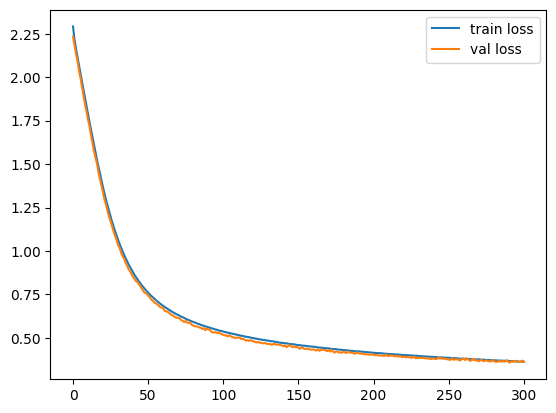

In [65]:
# # plot the training loss, and validation loss
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.legend()

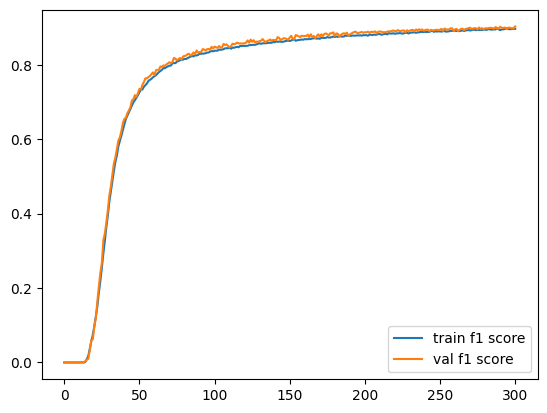

In [66]:
# # plot the training f1 score, and validation f1 score
# plt.plot(history.history['f1_score'], label='train f1 score')
# plt.plot(history.history['val_f1_score'], label='val f1 score')
# plt.legend()

In [74]:
# # use the fitted model and evaluate on evaluation set using f1 score
# y_pred_prob = model.predict(X_val)
# y_pred = np.argmax(y_pred_prob, axis=1)  # convert probabilities to class labels
# y_true = y_val

# f1 = f1_score(y_true, y_pred, average='macro')
# print('Macro average validation F1 score:', f1)
# print('Macro average validation F1 score from history:', history.history['val_f1_score'][-1])

39/60 [==================>...........] - ETA: 0s

60/60 [==============================] - 0s 1ms/step
Macro average validation F1 score: 0.9009302447253015
Macro average validation F1 score from history: 0.9029124975204468


### Hyperparameter Tuning

For the following algorithms, we will fine tune the mini-batch size Band the activation function
for the hidden layer to maximize the validation F1 score. The activation function should be one of {RELU,sigmoid, tanh}. The mini-batch size should be in range of [16, 1024]

In [21]:
activation_fns = ["relu", "sigmoid", "tanh"]
mini_batch_sizes = list(range(16, 1024+1, 1))

### Genetic Algorithm

On a very high-level, we are implementing the Genetic Algorithm where the chromosom representation is 13 bits (3 bit for one-hot encoded activation function mapping and 10 bits for for batch size-16). For each generation, we generate a population of 5 chromosomes, using the roulette rule to select two parents with replacement, a fixed one-point crossover with potential mutation to generate offsprings, and age based selection unload old chromosomes. If we a) reach a certain good enough fitness score, b) converge (aka, no improvement for the past few generations) or c) finish all generations, the search is terminated. 

#### chromesome

We start by converting the hyperparameters pairs into chromesome - each with 3 bits to representive the three activation functions we have, and 10 bits for the mini-batch sizes (technically 1024 will need 11 bits, but we start from 16, and thus, we keep track of batch_size-16\)

In [22]:
activation_mapping = {
    "relu": "100",
    "sigmoid": "010",
    "tanh": "001"
}
reversed_activation_mapping = {v: k for k, v in activation_mapping.items()}

In [23]:
def encode_hyperparameters(activation_fn, mini_batch_size):
    """generate a binary string encoding the activation function (3 bits) and mini-batch size (10 bits)"""
    # Encode activation function
    if activation_fn not in activation_mapping:
        raise ValueError("Invalid activation function")
    activation_binary = activation_mapping[activation_fn]

    # Encode mini-batch size (10 bits)
    if mini_batch_size < 16 or mini_batch_size > 1024:
        raise ValueError("Mini-batch size out of range")
    mini_batch_binary = format(mini_batch_size - 16, '010b') # 16 is the smallest mini-batch size

    # Combine activation function and mini-batch size into a single binary string
    chromosome = activation_binary + mini_batch_binary
    return chromosome

def decode_hyperparameters(chromosome):
    activation_fn = reversed_activation_mapping.get(chromosome[:3])
    if not activation_fn: raise ValueError("Invalid activation function")
    mini_batch_size = int(chromosome[3:], 2) + 16
    return activation_fn, mini_batch_size


In [112]:
# # Test
# activation_function = "tanh"
# batch_size = 1024

# chromosome = encode_hyperparameters(activation_function, batch_size)
# print("Chromosome:", chromosome)

Chromosome: 0101111110000


#### train and evaluate model

In [13]:
P=10
early_stopping = EarlyStopping(monitor='val_loss', patience=P,
                                    min_delta=0.001
                                   ) # restore_best_weights=False, doesn't matter for eval since we will train on train+val when we have the best hyperparameters

In [14]:
def train_and_eval(a, m, verbose=0):
    # Initialize tqdm for progress bar
    epochs_iterator = tqdm(range(E), desc=f'(a={a}, m={m}), Epochs:', leave=False)  # E is the number of epochs

    # train the model
    model = get_model(activation_fn=a)
    for epoch in epochs_iterator:
        history = model.fit(X_train, y_train_one_hot, epochs=1, validation_data=(X_val, y_val_one_hot),
                            batch_size=m, callbacks=[early_stopping], verbose=verbose)
        epochs_iterator.set_postfix({'val_f1_score': history.history['val_f1_score'][-1], 'val_loss': history.history['val_loss'][-1]})

    return history.history['val_f1_score'][-1]

In [176]:
# def train_and_eval(a, m, verbose=0):
#     # train the model
#     model = get_model(activation_fn=a)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=P, restore_best_weights=True)
#     history = model.fit(X_train, y_train_one_hot, epochs=E, validation_data=(X_val, y_val_one_hot), batch_size=m, callbacks=[early_stopping], verbose=verbose)
#     return history.history['val_f1_score'][-1]

#### roulette wheel parent selection

Based on what's covered in lab, we would sample two parent chromosomes (with replacement) from selected set of parents

In [25]:
def roulette_wheel_selection(fitness_score, parents=2):
    """select parents based on fitness score"""
    total_fitness = sum(fitness_score.values())
    probabilities = [fitness_score[c] / total_fitness for c in fitness_score]
    parents = np.random.choice(list(fitness_score.keys()), 
                               size=min(parents, len(fitness_score)), 
                               replace=True, 
                               p=probabilities)
    return parents

#### produce offsprings

As covered in lecture, since we know that the first 3 digits would be representing the activation funciton, and we are bounded to [16, 1024] batch size range, we're using **segmented crossover** (i.e, fix point) instead. Based on the fact that we have two parents, we have two children (`math.comb(2, 1) * math.comb(2, 1) - 2`).

Another part is mutation, here we have permissible range so we are using a **random resetting** - with probability, we mutate a child for its activation function or mini-batch size, with random resetting independently.

In [26]:
def crossover(parents):
    """generate two children based on single point crossover from two parents"""
    if len(parents) < 2: raise ValueError("Must have at least 2 parents for crossover.")
    crossover_point = 3 # 3 bits for activation function, 10 bits for mini-batch size
    child1 = parents[0][:crossover_point] + parents[1][crossover_point:]
    child2 = parents[1][:crossover_point] + parents[0][crossover_point:]
    return child1, child2

In [93]:
# child1, child2 = crossover(["0000000001", "0010000001"])
# child1, child2

('0000000001', '0010000001')

In [27]:
def mutation(child, p=.1): 
    """mutate a child with probability p"""
    mutated_child = ""
    
    # activation function
    if np.random.random() < p: 
        mutated_child += child[:3]
    else: 
        picks = [f for f in activation_mapping.values() if f != child[:3]]
        mutated_child += np.random.choice(picks) # within permissible range
    
    # mini-batch size
    if np.random.random() < p: 
        mutated_child += child[3:]
    else:
        mutated_child += format(np.random.randint(0, 1024-16+1), '010b') # within permissible range

    return mutated_child    

In [110]:
# mutated_child = mutation(child1, p=.5)
# child1, mutated_child # kept original activation function, but mutated mini-batch size

('0000000001', '0001101011000')

#### age-based selection

In [28]:
def age_based_selection(pop_age:dict, children:list, population:list):
    # age-based selection
    oldest = sorted(pop_age, key=pop_age.get, reverse=True)[:len(children)] # keeping the population size constant
    decode_oldest = [(decode_hyperparameters(c), pop_age[c]) for c in oldest]
    for c in oldest: 
        pop_age.pop(c)
        population.remove(c)
    # new generation
    population.extend(children)
    for c in children: pop_age[c] = 0
    decode_children = [decode_hyperparameters(c) for c in children]
    print(f"removed: {decode_oldest}; added: {decode_children}")
    return 

In [210]:
# population = ['1111001100110', '0010101010101', '1010010011001', '0101111100110', '1000110011001']  # Example population of chromosomes
# mutated_children = ['1110011100110', '0010111010101']  # Example list of mutated children
# pop_age = {chromosome: random.randint(1, 10) for chromosome in population}
# old_population = population.copy()
# old_pop_age = pop_age.copy()
# age_based_selection(pop_age, mutated_children, population)

removed: [(('relu', 425), 8), (('relu', 169), 6)]; added: [('relu', 246), ('relu', 485)]


In [218]:
# # diff in population
# decode_new = [decode_hyperparameters(c) for c in set(population) - set(old_population)]
# decode_old = [decode_hyperparameters(c) for c in set(old_population) - set(population)]
# decode_old, decode_new

([('relu', 425), ('relu', 169)], [('relu', 485), ('relu', 246)])

In [212]:
# sorted_old_pop_age = dict(sorted(old_pop_age.items(), key=lambda item: item[1], reverse=True))
# sorted_pop_age = dict(sorted(pop_age.items(), key=lambda item: item[1], reverse=True))
# sorted_old_pop_age, sorted_pop_age

({'1000110011001': 8,
  '1010010011001': 6,
  '0101111100110': 2,
  '1111001100110': 1,
  '0010101010101': 1},
 {'0101111100110': 2,
  '1111001100110': 1,
  '0010101010101': 1,
  '1110011100110': 0,
  '0010111010101': 0})

#### run algo

In [109]:
# for NN
E = 2000 # epochs to run
CP = 10 # chromosome patience

# for GA
G = 50 # generations
PS = 5 # population size
GP = 5 # generation patience
MP = 0.1 # mutation probability
GEF = .95 # good enough fitness

exhausted_ind = False
gen_wo_improvement = 0

##### log

In [52]:
def initialize_log(file_name:str, log: Union[List, Dict]):
    """initialize log from file, if it exists"""
    if isinstance(log, list):
        log = []
    elif isinstance(log, dict):
        log = {}
        
    if os.path.exists(file_name):
        print(f"Loading {file_name} from log.")
        with open(file_name, "r") as f:
            log = yaml.load(f, Loader=yaml.FullLoader)
    return log

In [103]:
# !rm -r logs/
# !mkdir -p logs

In [104]:
population_log = r'logs/population.yml'
population = initialize_log(population_log, [])

best_fitness_by_gen_log = r'logs/best_fitness_by_gen.yml'
best_fitness_by_gen = initialize_log(best_fitness_by_gen_log, [])

avg_fitness_by_gen_log = r'logs/avg_fitness_by_gen.yml'
avg_fitness_by_gen = initialize_log(avg_fitness_by_gen_log, [])

pop_age_log = r'logs/pop_age.yml'
pop_age = initialize_log(pop_age_log, {})

fitness_score_log = r'logs/fitness_score.yml'
fitness_score = initialize_log(r'logs/fitness_score.yml', {})

##### population

In [105]:
def generate_all_pairs(activation_fns, mini_batch_sizes, fitness_score=fitness_score):
    """generate all possible pairs of activation functions and mini-batch sizes as a shuffled queue"""
    all_pairs = [encode_hyperparameters(fn, size) for fn in activation_fns for size in mini_batch_sizes]
    all_pairs = [pair for pair in all_pairs if pair not in fitness_score]
    return all_pairs

all_pairs = generate_all_pairs(activation_fns, mini_batch_sizes)

In [106]:
def enqueue_pairs(all_pairs):
    """shuffle the list of pairs and enqueue them into a queue"""
    random.shuffle(all_pairs)
    pairs_queue = queue.Queue()
    for pair in all_pairs:
        pairs_queue.put(pair)
        
    return pairs_queue
    
pairs_queue = enqueue_pairs(all_pairs)
pairs_queue.qsize() # 3* (1024-16+1) = 3072

3027

In [ ]:
# checking for randomness
# num_iterations = 10
# for i in range(num_iterations):
#     if not all_pairs.empty():
#         pair = decode_hyperparameters(all_pairs.get())
#         print(f"Iteration {i + 1}: Dequeued pair - Activation Function: {pair[0]}, Mini Batch Size: {pair[1]}")
#     else:
#         print("Queue is empty.")
#         break

Iteration 1: Dequeued pair - Activation Function: relu, Mini Batch Size: 986
Iteration 2: Dequeued pair - Activation Function: relu, Mini Batch Size: 342
Iteration 3: Dequeued pair - Activation Function: relu, Mini Batch Size: 761
Iteration 4: Dequeued pair - Activation Function: relu, Mini Batch Size: 946
Iteration 5: Dequeued pair - Activation Function: relu, Mini Batch Size: 371
Iteration 6: Dequeued pair - Activation Function: relu, Mini Batch Size: 840
Iteration 7: Dequeued pair - Activation Function: relu, Mini Batch Size: 385
Iteration 8: Dequeued pair - Activation Function: relu, Mini Batch Size: 388
Iteration 9: Dequeued pair - Activation Function: relu, Mini Batch Size: 1017
Iteration 10: Dequeued pair - Activation Function: relu, Mini Batch Size: 987


In [107]:
def update_population(pairs_queue=pairs_queue, population=[], population_size=5):
    """generate a population of chromosomes, intended to be called for the following loop:
        - we start off with an empty population at the beginning
        - at each generation:
            - if we exhaust all pairs: 
                - just continue with the current population
            - else:
                - add new chromosomes from the queue until we have enough
            - we return the updated population and a flag indicating if we have exhausted all pairs
    """
    
    # error-handling
    if population is None:
        population = []
    if pairs_queue is None:
        raise ValueError("Queue not provided.")

    exhausted_ind = False

    # add to population if not enough
    while len(population) < population_size:
        # all pairs are exhausted
        if pairs_queue.empty(): 
            print("Queue is empty. Last population generated.")
            exhausted_ind = True
            break
        
        chromosome = pairs_queue.get()
        population.append(chromosome)
    
    return population, exhausted_ind

###### quick test

In [ ]:
# # try the update population function
# population, exhausted_ind = update_population(pairs_queue, fitness_score, population=[], population_size=5)
# print(f"Population: {population}")

Population: ['0000101011100', '0011000100000', '0010111111011', '0000010001010', '0011011100011']


In [ ]:
# pairs_queue.qsize(), exhausted_ind

(3022, False)

In [ ]:
# # add them to the fitness score
# for chromosome in population:
#     fitness_score[chromosome] = 0.8

In [ ]:
# # try again the function
# population, exhausted_ind = update_population(pairs_queue, fitness_score, population=population, population_size=5)
# print(f"Population: {population}")

Population: ['0000011000001', '0000110100001', '0101110111101', '0010111101101', '0001110001110']


In [ ]:
# pairs_queue.qsize(), exhausted_ind

(3017, False)

##### main
For the main function, we are running loops for generations `G` with the following termination criteria: 
    
    - no improvement in population fitness score for `GP` generations
    - reaching a certain number of iterations
    - fitness is good enough
    - (optinal) exhausted all pairs, implmented but not reasonable for this homework

In [116]:
G -= len(best_fitness_by_gen) # skip iterated generations
for g in tqdm(range(G), desc='Generations'):

    # update population - fail-safe
    population, exhausted_ind = update_population(pairs_queue, population, population_size=PS)        
    with open(population_log, "w") as file:
        yaml.dump(population, file)
    
    # update population age to log - fail-safe
    if len(pop_age) > 0:
        with open(pop_age_log, "w") as file:
            yaml.dump(pop_age, file)
    
    # keep track of population fitness score
    pop_fitness_score = {} # key: chromosome, value: fitness score
    
    # iterate the population, calculate the fitness score
    for c in tqdm(population, desc='Chromosomes', leave=False):
        
        # decode the chromosome for activation function and mini-batch size
        a, m = decode_hyperparameters(c)
        
        # for unvisited chromosomes:
        # compute the validation F1 for ea. chromosomes at convergence, mark as visited
        if c not in fitness_score: 
            f = train_and_eval(a, m) # f: fitness score, e: epochs
            fitness_score[c] = f
            # mark chromosomes visited
            with open(fitness_score_log, "a") as file:
                yaml.dump({c: f}, file)
            print(f"{a}-{m} marked visited. Fitness score: {f}")
        else: 
            f = fitness_score[c]
            print(f"{a}-{m} has been visited. Fitness score: {f}")
    
        # update population fitness score and age
        pop_fitness_score[c] = f
        pop_age[c] = pop_age.get(c, 0) + 1
        
    # add the best fitness score per gen
    best_fitness_by_gen.append(max(pop_fitness_score.values()))
    with open(best_fitness_by_gen_log, "w") as file:
        yaml.dump(best_fitness_by_gen, file)
        
    # add the average fitness score per gen
    avg_fitness_by_gen.append(sum(pop_fitness_score.values())/len(pop_fitness_score))
    with open(avg_fitness_by_gen_log, "w") as file:
        yaml.dump(avg_fitness_by_gen, file)
        
    # break criteria: exhausted all pairs
    if exhausted_ind: 
        print(f"Termninates at {g+1}th generation, all pairs are exhausted.")
        break
    
    # break criteria: good enough fitness
    curr_gen_best_fitness = best_fitness_by_gen[-1]
    if curr_gen_best_fitness >= GEF:
        print(f"Terminates at {g+1}th generation, good enough fitness reached.")
        break
    
    # break criteria: no improvement in consecutive GP generations
    if g >= GP: 
        prev_gens_best_fitness = max(best_fitness_by_gen[:-1])
        if curr_gen_best_fitness <= prev_gens_best_fitness:
            gen_wo_improvement += 1
            if gen_wo_improvement >= GP:
                print(f"Terminates at {g + 1}th generation, no improvement in population over {GP} generations.")
                break
        else:
            gen_wo_improvement = 0
    
    # select parents - default to 2 parents
    parents = roulette_wheel_selection(pop_fitness_score)
    decoded_parents = [decode_hyperparameters(p) for p in parents]
    print(f"Parents: {decoded_parents}")
    
    # produce offsprings
    children = crossover(parents)
    mutuated_children = [mutation(child, p=MP) for child in children]
    decoded_mutated_children = [decode_hyperparameters(c) for c in mutuated_children]
    print(f"Mutated children: {decoded_mutated_children}")
    
    # age-based seletion ->  new generation
    age_based_selection(pop_age, mutuated_children, population)

    
    # remove duplicates to avoid imbreddings -> removed per recommendations from the office hours
    # # we're already getting parents with replacement, trying more exploration instead of exploitation
    # population = list(set(population))
    

Generations:   0%|          | 0/47 [00:00<?, ?it/s]

Chromosomes:   0%|          | 0/5 [00:00<?, ?it/s]

relu-788 has been visited. Fitness score: 0.829483151435852


(a=tanh, m=20), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

tanh-20 marked visited. Fitness score: 0.9551747441291809


(a=sigmoid, m=754), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

sigmoid-754 marked visited. Fitness score: 0.0
sigmoid-945 has been visited. Fitness score: 0.0
sigmoid-589 has been visited. Fitness score: 0.0011049724416807294
Terminates at 1th generation, good enough fitness 0.95 reached.


Plot the average and the highest fitness score of the population versus the generation of the population.

##### report

Loading logs/best_fitness_by_gen.yml from log.


(0.0, 1.0)

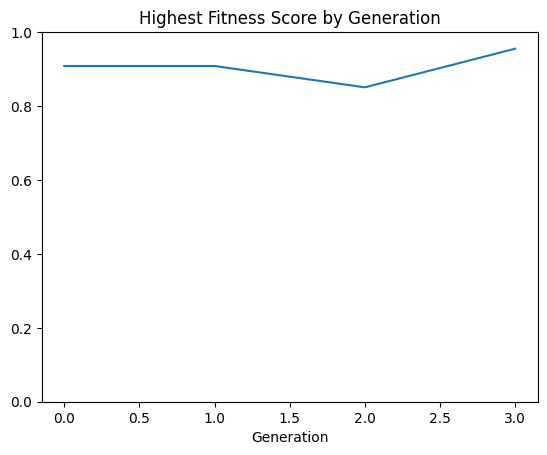

In [54]:
# plot the highest fitness score by gen
best_fitness_by_gen = initialize_log(r'logs/best_fitness_by_gen.yml', [])
plt.plot(best_fitness_by_gen)
plt.title("Highest Fitness Score by Generation")
plt.xlabel("Generation")
plt.ylim(0, 1)

Loading logs/avg_fitness_by_gen.yml from log.


(0.0, 1.0)

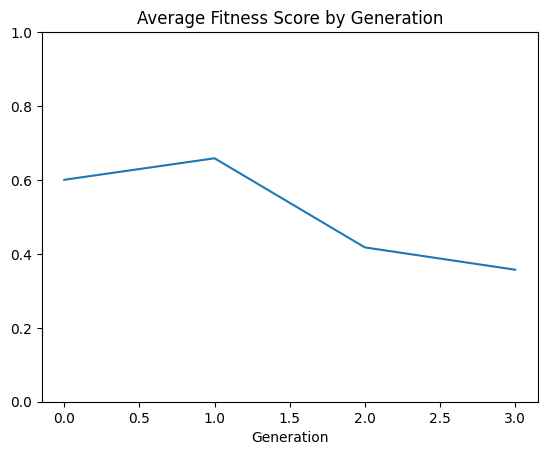

In [53]:
# plot the average best fitness score by gen
avg_fitness_by_gen = initialize_log(r'logs/avg_fitness_by_gen.yml', [])
plt.plot(avg_fitness_by_gen)
plt.title("Average Fitness Score by Generation")
plt.xlabel("Generation")
plt.ylim(0, 1)

Now, a very quick note about our plots. Though we have other termination criteria in-place, we ended up with  a very fast termination due to reaching a good enough fitness score in the third generation. Here, we see that the best keeps the upward trajectory, while average dips a little. My understanding is that genetic algo should favor exploration to exploitation at the beginning of the generation, and the ultimate goal should not be about having a bunch of higher than average chromosomes who most likely suffer from imbredding - it should be about having a very good, cream of the corp chromosome, even though others in the chromosome might or might not be less than ideal. And that explains what we see here - the model is set on the next generation "inheriting" the best qualities (thus the increase in best) while exploring other options (which didn't end up quite well, thus the decrease in average for a bit). If we didn't end up on a GFE, we will see more generations, and I would expect that the average goes up as well. 

Note that, since we have a fix one point crossover with only two parents (who are also likely to be the same), with the right roulette wheel, we effectively synthesizes  elitism - the selection strategy that keeps the best individuals from one generation to the next. Such a strategy also speeds up the convergence of the algorithm.

Select the vector with the highest fitness score in the last generation of the population. Report the hyperparameters

In [119]:
# last generation
population = initialize_log(r'logs/population.yml', [])
# find highest fitness score, with keys in population
max_fitness = 0
for c in set(population) & set(fitness_score.keys()):
    if fitness_score[c] > max_fitness:
        max_fitness = fitness_score[c]
        best_chromosome = c
# report hyperparameters
best_a, best_m = decode_hyperparameters(best_chromosome)
print("Vector with the highest fitness score:", best_chromosome)
print(f"Hyperparameter: Activation Function: {best_a}, Mini Batch Size: {best_m}")

Loading logs/population.yml from log.
Vector with the highest fitness score: 0010000000100
Hyperparameter: Activation Function: tanh, Mini Batch Size: 20


Train the model on the training and validation data using the selected hyperparameters. 

Here, we are bringning back the original `train_X.npy` (train+val for genetics algorithm) as our training data. We then check for best parameters based on the fitness score. 

In [172]:
# select the best hyperparameters
fitness_score = initialize_log(r'logs/fitness_score.yml', {})
best_chromosome = max(fitness_score, key=fitness_score.get)
best_a, best_m = decode_hyperparameters(best_chromosome)
best_a, best_m, fitness_score[best_chromosome]

Loading logs/fitness_score.yml from log.


('tanh', 20, 0.9551747441291809)

In [173]:
# reload the data
X_train = np.load('data/train_X.npy')
X_test = np.load('data/test_X.npy')
y_train = np.load('data/train_y.npy')
y_test = np.load('data/test_y.npy')
X_train.shape, X_test.shape, y_train.shape, y_test.shape # 50/50 split for train/test

# reshape for NN input
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# one-hot encode the labels
y_train_one_hot = one_hot_matrix(y_train)
y_test_one_hot = one_hot_matrix(y_test)

In [174]:
# train the model with the best hyperparameters
E = 2000
model = get_model(activation_fn=best_a)
# early_stopping = EarlyStopping(monitor='loss', patience=P, restore_best_weights=True)

# Create tqdm progress bar for epochs
epochs_iterator = tqdm(range(E), desc=f'(a={best_a}, m={best_m}), Epochs:', leave=False)
training_f1 = []

for epoch in epochs_iterator:
    # Fit the model for each epoch
    history = model.fit(
        X_train,
        y_train_one_hot,
        epochs=1,  # 1 epoch at a time to update tqdm
        batch_size=best_m,
        # callbacks=[early_stopping], # run for the entirety
        verbose=0
    )
    training_f1.append(history.history['f1_score'][-1])
    
    # Update tqdm with F1 score and loss for the last epoch
    epochs_iterator.set_postfix(
        {'f1_score': history.history['f1_score'][-1], 'loss': history.history['loss'][-1]}
    )

(a=tanh, m=20), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

In [180]:
# save the files
model.save(f"models/GA-{best_a}_{best_m}.h5")

Evaluate the model on the test data. Plot the training F1 score versus the training epochs. Report the test F1 score.

In [177]:
model = tf.keras.models.load_model(f"models/GA-{best_a}_{best_m}.h5")

In [178]:
# evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test
f1 = f1_score(y_true, y_pred, average='macro')
print('Macro average test F1 score:', f1)

33/33 [==============================] - 0s 2ms/step
Macro average test F1 score: 0.9581721252501824


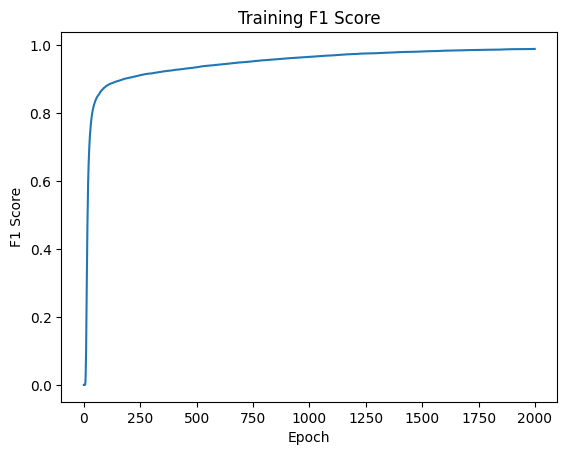

In [126]:
# plot the training F1 s score versus the training epochs
plt.plot(training_f1)
plt.title("Training F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.show()

### Bayesian Optimization

We will use the package [here](https://github.com/bayesian-optimization) to apply Bayesian Optimization to fine tune the mini-batch size Band the activation function. 

The black-box function should be defined as the validation F1 score at the convergence of the model trained by the specified Band the activation function. 

Here - we are using the same function as from Genetic Algorithm as our black box, which returns validation F1 score and use early stopping to check for convergence.

In [10]:
activation_fn_mapping = {
    0: 'relu',
    1: 'sigmoid',
    2: 'tanh'
}

In [11]:
# black-box function is the same as train_and_eval
def black_box_function(a, m):
    return train_and_eval(a, m)

According to [doc](notebooks/advanced-tour.ipynb), "there is no principled way of dealing with discrete parameters using this package", and thus, we are using a wrapper function that converts them as suggested.

In [15]:
# wrapper to make sure we are passing in the right types
def func_to_be_optimized(activation_fn_cd: float, batch_size:float) -> float:
    """wrapper function for the black-box function to that we optimize for discrete values"""
    if activation_fn_cd == 3: activation_fn_cd = 2 # tanh is the last one
    a = activation_fn_mapping.get(int(activation_fn_cd))
    m = int(batch_size)
    return black_box_function(a, m)

In [16]:
# Define the search space
pbounds = {'activation_fn_cd': (0,3), 'batch_size': (16, 1024)} # added 3 so that we can get to tanh when taking int

In [37]:
# Create an instance of BayesianOptimization
optimizer = BayesianOptimization(
    f=func_to_be_optimized,
    pbounds=pbounds,
    random_state=RANDOM_STATE,
)

In [150]:
# visited_cnt = len(fitness_score)

11

Report the progress output and the final values of the hyperparameters found by the algorithm. 

According to [doc](notebooks/basic-tour.ipynb), `n_iter` is how many steps of bayesian optimization we want to perform and `init_points` are how many steps of random we want to perform - which means the the total iterations would be the sum of these two numbers. The Genetic Algorithm approach visited 11 pairs. So we hope that giving a 15 iterations try would be reasonable.

In [20]:
## repeat load the data process - reshape, train/val split and one-hot encode
# load data
X_train = np.load('data/train_X.npy')
X_test = np.load('data/test_X.npy')
y_train = np.load('data/train_y.npy')
y_test = np.load('data/test_y.npy')

# reshape for NN input
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# 80/20 train_val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# one-hot encode
y_train_one_hot = one_hot_matrix(y_train)
y_val_one_hot = one_hot_matrix(y_val)
y_test_one_hot = one_hot_matrix(y_test)

In [21]:
E = 2000 # epochs to run

In [22]:
P = 10 # patience
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=P, 
                               min_delta=0.001,
                               restore_best_weights=True)

In [28]:
# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Access the best parameters found
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

|   iter    |  target   | activa... | batch_... |
-------------------------------------------------


(a=sigmoid, m=974), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 1         | 0.0       | 1.124     | 974.3     |


(a=tanh, m=619), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 2         | 0.8474    | 2.196     | 619.4     |


(a=relu, m=173), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 3         | 0.9028    | 0.4681    | 173.2     |


(a=relu, m=889), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 4         | 0.8028    | 0.1743    | 889.1     |


(a=sigmoid, m=729), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 5         | 0.0       | 1.803     | 729.7     |


(a=relu, m=171), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 6         | 0.9039    | 0.6058    | 171.9     |


(a=tanh, m=547), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 7         | 0.854     | 2.977     | 547.7     |


(a=relu, m=69), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 8         | 0.9255    | 0.02854   | 69.92     |


(a=tanh, m=296), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 9         | 0.8891    | 3.0       | 297.0     |


(a=tanh, m=400), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 10        | 0.8711    | 2.776     | 400.4     |


(a=relu, m=471), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 11        | 0.8658    | 0.0       | 472.0     |


(a=sigmoid, m=16), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 12        | 0.9248    | 1.198     | 16.04     |


(a=tanh, m=243), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 13        | 0.8957    | 2.671     | 243.6     |


(a=tanh, m=838), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 14        | 0.8254    | 3.0       | 838.7     |


(a=relu, m=349), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 15        | 0.8776    | 0.0       | 349.1     |
Best Hyperparameters: {'activation_fn_cd': 0.0285430826314359, 'batch_size': 69.91754303513063}


In [35]:
best_a = activation_fn_mapping.get(int(best_params['activation_fn_cd']))
best_m = int(best_params['batch_size'])
print("Best Hyperparameters:", best_a, best_m)

Best Hyperparameters: relu 69


Based on the guidance from the office hour, we are trying to see if we can get a better result (i.e., validation macro average F1 closer to .95) with other methods. Options include trying different seeds or increasing iteration. Here, we try probing from our best parameters from the Genetic Algorithm as an alternative.

In [32]:
del optimizer # fresh start

In [38]:
# Create an instance of BayesianOptimization
optimizer = BayesianOptimization(
    f=func_to_be_optimized,
    pbounds=pbounds,
    random_state=RANDOM_STATE,
)

In [39]:
# probe the best parameters - e.g., winning strategy from Genetic Algorithm
optimizer.probe(
    params={'activation_fn_cd': 2, "batch_size": 20},
    lazy=True,
)

In [40]:
# Perform the optimization
optimizer.maximize(init_points=5, n_iter=10)

# Access the best parameters found
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

|   iter    |  target   | activa... | batch_... |
-------------------------------------------------


(a=tanh, m=20), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 1         | 0.9491    | 2.0       | 20.0      |


(a=sigmoid, m=974), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 2         | 0.0       | 1.124     | 974.3     |


(a=tanh, m=619), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 3         | 0.8523    | 2.196     | 619.4     |


(a=relu, m=173), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 4         | 0.9031    | 0.4681    | 173.2     |


(a=relu, m=889), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 5         | 0.8031    | 0.1743    | 889.1     |


(a=sigmoid, m=729), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 6         | 0.0       | 1.803     | 729.7     |


(a=relu, m=19), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 7         | 0.9518    | 0.6279    | 19.75     |


(a=relu, m=94), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 8         | 0.9145    | 0.08606   | 94.76     |


(a=sigmoid, m=527), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 9         | 0.09284   | 1.747     | 527.7     |


(a=tanh, m=251), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 10        | 0.8954    | 2.985     | 251.9     |


(a=relu, m=334), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 11        | 0.8861    | 0.0       | 334.6     |


(a=tanh, m=402), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 12        | 0.8745    | 3.0       | 402.8     |


(a=tanh, m=833), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 13        | 0.8231    | 3.0       | 833.3     |


(a=relu, m=55), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 14        | 0.9215    | 0.0       | 55.97     |


(a=relu, m=292), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 15        | 0.8901    | 0.0       | 292.5     |


(a=tanh, m=135), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

| 16        | 0.91      | 3.0       | 135.3     |
Best Hyperparameters: {'activation_fn_cd': 0.6278632845903596, 'batch_size': 19.749418104603663}


In [41]:
best_a = activation_fn_mapping.get(int(best_params['activation_fn_cd']))
best_m = int(best_params['batch_size'])
print("Best Hyperparameters:", best_a, best_m)

Best Hyperparameters: relu 19


With probe, we get another set of hyperparameters that gives us the macro-averge F1 of >.95 on validation set. Our next step is again to train the model with both train and valiation data and report the final test F1 score.

In [ ]:
# also available
# tunning the Gaussian Process
# optimizer.set_gp_params(alpha=1e-3, n_restarts_optimizer=5)

Train the model on the training and validation data using the selected hyperparameters. Evaluate the
model on the test data. Plot the training F1 score versus the training epochs. Report the test F1
score.

Like previously, we using all `train_X.npy` as the X_train.

In [42]:
# reload the data
X_train = np.load('data/train_X.npy')
X_test = np.load('data/test_X.npy')
y_train = np.load('data/train_y.npy')
y_test = np.load('data/test_y.npy')
X_train.shape, X_test.shape, y_train.shape, y_test.shape # 50/50 split for train/test

# reshape for NN input
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# one-hot encode the labels
y_train_one_hot = one_hot_matrix(y_train)
y_test_one_hot = one_hot_matrix(y_test)

In [44]:
# train the model with the best hyperparameters
E = 2000
model = get_model(activation_fn=best_a)
# early_stopping = EarlyStopping(monitor='loss', patience=P, restore_best_weights=True)

# Create tqdm progress bar for epochs
epochs_iterator = tqdm(range(E), desc=f'(a={best_a}, m={best_m}), Epochs:', leave=False)
training_f1 = []

for epoch in epochs_iterator:
    # Fit the model for each epoch
    history = model.fit(
        X_train,
        y_train_one_hot,
        epochs=1,  # 1 epoch at a time to update tqdm
        batch_size=best_m,
        # callbacks=[early_stopping], # run for the entirety
        verbose=0
    )
    training_f1.append(history.history['f1_score'][-1])
    
    # Update tqdm with F1 score and loss for the last epoch
    epochs_iterator.set_postfix(
        {'f1_score': history.history['f1_score'][-1], 'loss': history.history['loss'][-1]}
    )

(a=relu, m=19), Epochs::   0%|          | 0/2000 [00:00<?, ?it/s]

In [48]:
# save the model to models
model.save(f"models/BO-{best_a}-{best_m}.h5")

In [49]:
# evaluate the model
model = tf.keras.models.load_model(f"models/BO-{best_a}-{best_m}.h5")
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test
f1 = f1_score(y_true, y_pred, average='macro')
print('Macro average test F1 score:', f1)

33/33 [==============================] - 0s 1ms/step
Macro average test F1 score: 0.9604812253382133


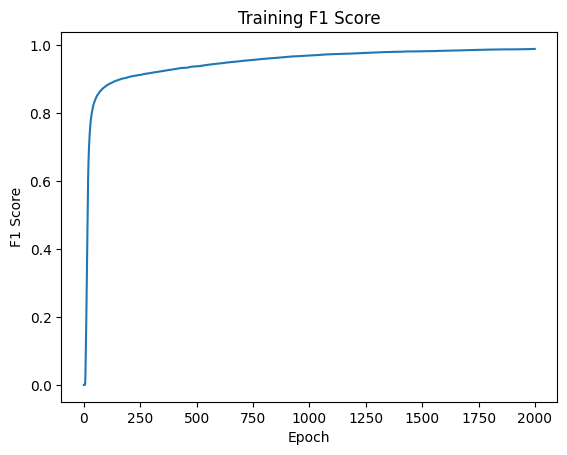

In [50]:
# plot the training F1 s score versus the training epochs
plt.plot(training_f1)
plt.title("Training F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.show()

Compare the hyperparameters chosen by the Genetic Algorithm and the Bayesian Optimization method.
Briefly discuss the pros and cons of the two methods.

**Parameters Comparison**

The best hyperparameters for Genetic Algorithm (GA) is using 'tanh' as the activation funciton with the batch size of 20. That gives us the test F1 of 95.52%. The best hyperparameters for Bayesian Optimization (BO) is using 'relu' as the activation funciton with the batch size of 19. That gives us the test F1 of 96.05%.

**Pros and Cons**

Granted, we don't cover a lot about either during the lecture, so I am reverting a lot to [this paper](http://cs.ndsu.edu/~siludwig/Publish/papers/CEC2021.pdf), and try to tie it to what I see during the training process. 

GAs are considered global searchs, and are robust against getting stuck in local optima due to their stochastic nature and ability to maintain diversity in the population. The con, versus BO, we have some many more hyperparameters to tune - # of generations to run, mutation probability, hack, we even have three ways of terminate criteria on paper and we have to decide on the hyperparameters for these as well. So on that note, it requires a decent understanding of the problem. 

BO is known for its efficiency and flexibility. It's efficient because converges pretty fast. Comparing to GA, BO is considered more sample efficient - in each iteration, the surrogate model is fitted to all observations of the target function made so far, and is capable of predicting how untested combinations will perform, so it can get the most out of every sample. Empiracally, we can see that in GA, the average fitness score of the first generation was around 60%, versus in BO, we got high 70% in the very first hyperparameter pairs we tried. BO only requires the choice of surrogate function and acqusition function - the package we are using comes with gaussian processes so we don't even have to define it ourself, just plug in the black box function and viola, here're the results. Comparing to GAs' many many hyperparameters to decide on first, that is pretty hassle-free. The hidden con is that the computational complexity of a Bayesian method is highly dependent on the particular model used, and at each each data point, the posterior distribution can become more and more complex. We are only running it for 15 iterations so the difference is not very distinguishable, but according to the paper, "BO consumed more time than the genetic algorithm to find the best parameters", which if you took a close look, is more than doubling the time and a worse result for the specific problem mentioned in the paper:

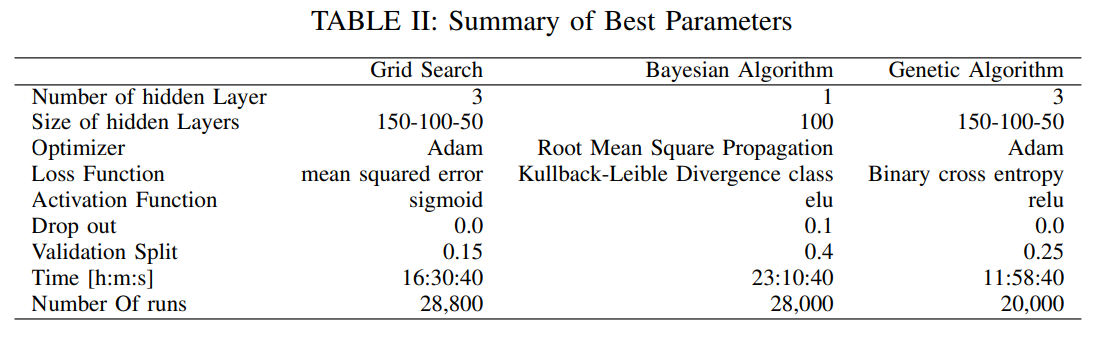

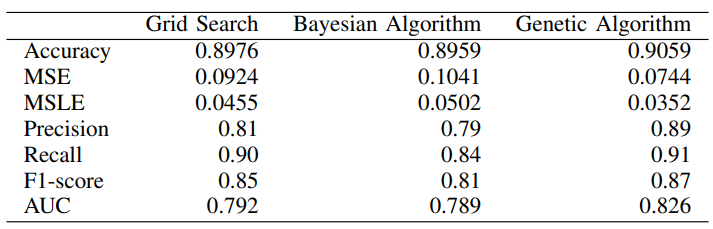

Some general pros and cons: both GA and BO can handle both continuous and discrete hyperparameters, so it's also considered a pro according to the paper. And of course, the randomness also means that they may not always converge to the global optimium and can be sensitive to initial population. They can also be computationally expensive, especially when the search spaces is structued on a very high dimension and can grow expotentially. Both are also parallelizable - we can see that at each generation, the computation of the fitness score of any one chromosome is not determined on another so we can easily run in parallel provided we have the computation resources. We can also run BO in parallel, even given the sequential nature. One common approach is with asynchronous Bayesian Optimization, where we take into account the hyperparameter that is currently being run, without knowledge of what the result might be. There are also other methods like predictive entropy search for multi-objective Bayesian optimization (PESMO), which is designed for parallel and multi-objective settings.

### 